In [1]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_theme(style="whitegrid")

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

import os
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import matplotlib.patches as mpatches

In [2]:
DB_HOST = '151.100.179.29'
DB_PORT =5432
DB_USER = 'admin'
DB_PASSWORD = 'admin'
DB_NAME = 'bigbrotr'

bigbrotr = psycopg2.connect(
    host=DB_HOST,
    port=DB_PORT,
    user=DB_USER,
    password=DB_PASSWORD,
    dbname=DB_NAME
)

DATA_FOLDER = '../../data/'

In [3]:
relays_w_metadata = pd.read_sql(
    '''
    SELECT DISTINCT ON (relay_url) relay_url
    FROM relay_metadata
    ''', bigbrotr
)
relays = pd.read_sql('SELECT url, network FROM relays', bigbrotr)
relays['metadata'] = relays['url'].isin(relays_w_metadata['relay_url'])
with_metadata_count = relays['metadata'].sum()
total_relays = relays.shape[0]
print(f"Total relays: {total_relays}, with metadata: {with_metadata_count} ({with_metadata_count/total_relays:.2%})")
print("Network distribution for relays with metadata:")
tmp = relays[relays['metadata']]['network'].value_counts().reset_index()
tmp['perc'] = tmp['count'] / tmp['count'].sum() * 100
for _, row in tmp.iterrows():
    print(f"- {row['network']}: {row['count']} ({row['perc']:.2f}%)")

Total relays: 8865, with metadata: 1241 (14.00%)
Network distribution for relays with metadata:
- clearnet: 993 (80.02%)
- tor: 248 (19.98%)


In [4]:
relay_metadata = pd.read_sql(
    '''
    SELECT *
    FROM relay_metadata
    ''', bigbrotr
)
relay_metadata = pd.merge(relay_metadata, relays.filter(['url', 'network']).rename(columns={'url': 'relay_url'}), how='left')

<Axes: title={'center': 'Relay metadata count distribution'}, ylabel='Frequency'>

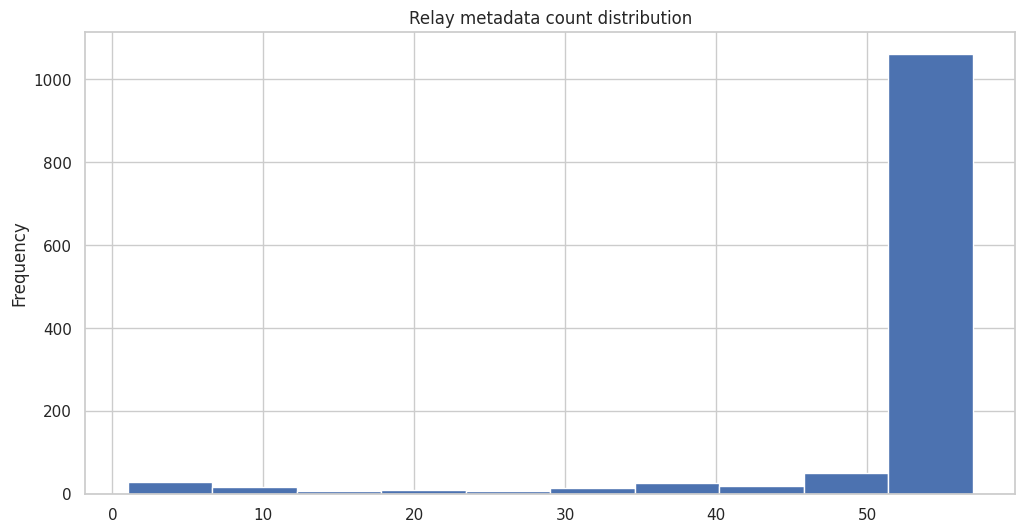

In [5]:
relay_metadata.value_counts('relay_url').plot(kind='hist', title='Relay metadata count distribution')

In [6]:
tmp = relay_metadata.copy()
tmp['date'] = pd.to_datetime(tmp['generated_at'], unit='s').dt.date
tmp_daily = tmp.sort_values(['relay_url', 'generated_at']).drop_duplicates(subset=['relay_url', 'date'])
tmp_daily = tmp_daily.set_index(['relay_url', 'date'])

Total unique relays with metadata: 1241


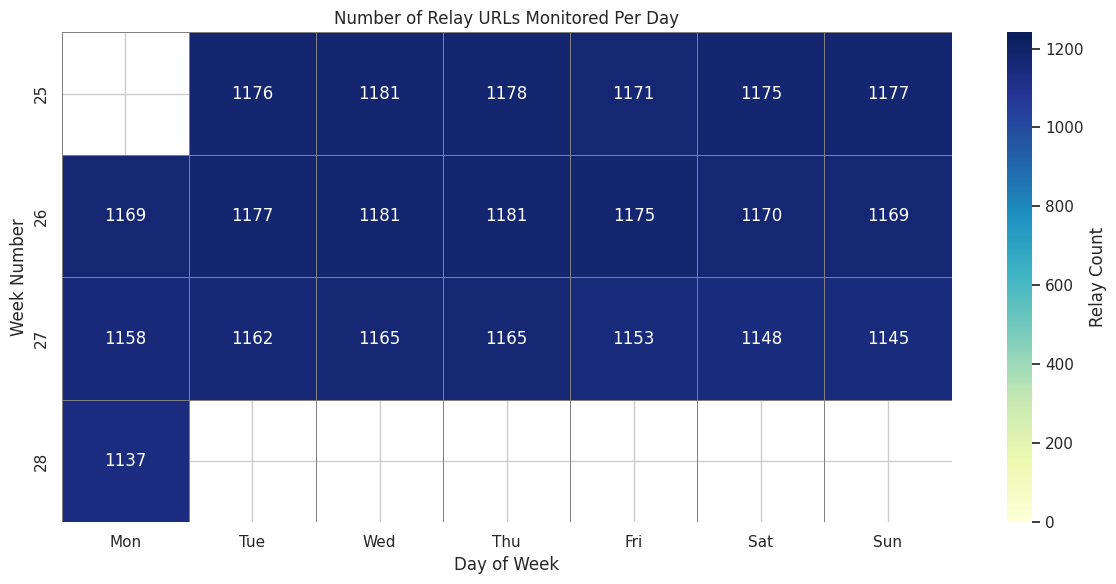

In [7]:
print(f"Total unique relays with metadata: {tmp_daily.index.get_level_values('relay_url').nunique()}")

# --- Prep: Assume tmp_daily already exists ---
# Count number of relays per day
daily_counts = tmp_daily.reset_index().groupby('date')['relay_url'].nunique()
daily_counts = daily_counts.to_frame(name='relay_count')
daily_counts.index = pd.to_datetime(daily_counts.index)

# Total number of unique relays (to use as cap)
max_relays = tmp_daily.index.get_level_values('relay_url').nunique()

# Add week and weekday columns
daily_counts['week'] = daily_counts.index.isocalendar().week
daily_counts['dow'] = daily_counts.index.weekday  # Monday=0

# Pivot for heatmap
pivot_table = daily_counts.pivot(index='week', columns='dow', values='relay_count')

# Cap values at total number of relays
pivot_table = pivot_table.clip(upper=max_relays)

# Ensure all weekdays are present (0=Mon, 6=Sun)
pivot_table = pivot_table.reindex(columns=range(7))

# Optional: Replace weekday numbers with labels
pivot_table.columns = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plot heatmap with annotations
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt='.0f', linewidths=0.5, linecolor='gray',
            vmin=0, vmax=max_relays, cbar_kws={'label': 'Relay Count'})
plt.title('Number of Relay URLs Monitored Per Day')
plt.xlabel('Day of Week')
plt.ylabel('Week Number')
plt.tight_layout()
plt.show()

In [8]:
metrics = ['connection_success', 'nip11_success', 'readable', 'writable', 'openable']
networks = ['clearnet', 'tor', 'all']
nip11_cols = ['name', 'description', 'banner', 'icon', 'pubkey', 'contact', 'supported_nips', 'software', 'version', 'privacy_policy', 'terms_of_service', 'limitation', 'extra_fields']

def mode_of_series(series):
    """Calculate the mode (most frequent value) of a Series."""
    if series.empty:
        return None
    mode_series = series.mode()
    if mode_series.empty:
        return None
    return mode_series.iloc[0]

def mode_of_lists(series):
    tuples = series.apply(lambda x: tuple(x) if isinstance(x, list) else x)
    if tuples.empty:
        return []
    mode_series = tuples.mode()
    if mode_series.empty:
        return []
    mode_tuple = mode_series.iloc[0]
    return list(mode_tuple) if isinstance(mode_tuple, tuple) else mode_tuple

def mode_of_dicts(series):
    def dict_to_tuple(d):
        if isinstance(d, dict):
            return tuple(sorted(d.items()))
        return d
    tuples = series.apply(dict_to_tuple)
    if tuples.empty:
        return {}
    mode_series = tuples.mode()
    if mode_series.empty:
        return {}
    mode_tuple = mode_series.iloc[0]
    return dict(mode_tuple) if isinstance(mode_tuple, tuple) else mode_tuple

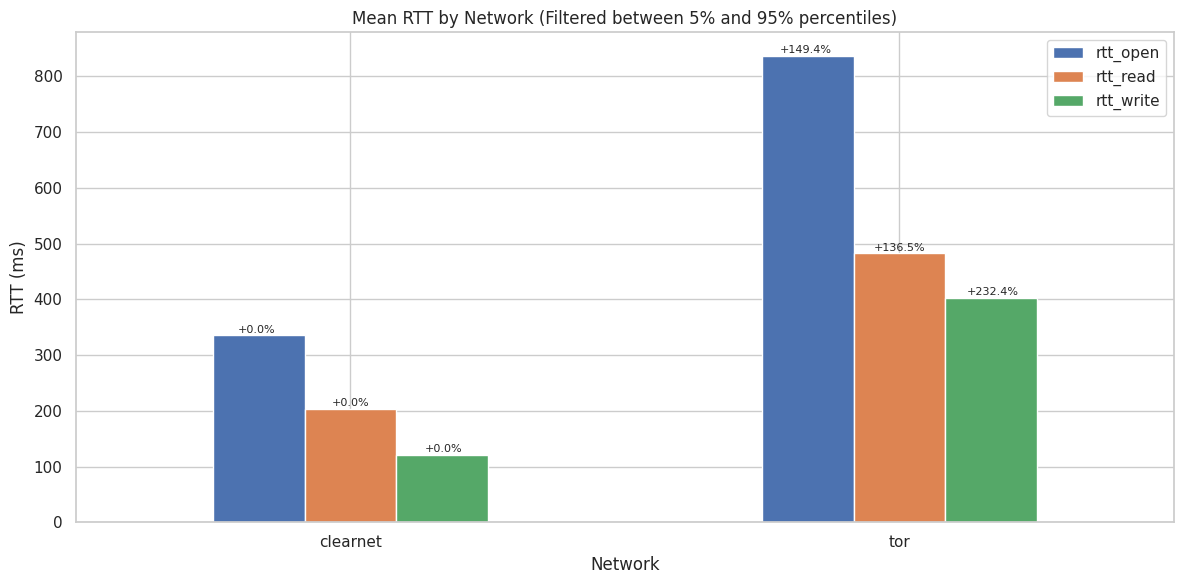

In [9]:
def plot_mean_rtt_percentile_filter(df, rtt_columns, lower_pct=0.05, upper_pct=0.95):
    """
    df: dataframe originale con 'network' e colonne RTT
    rtt_columns: lista colonne RTT su cui filtrare outlier con percentili
    lower_pct: percentile inferiore (es. 0.05 = 5%)
    upper_pct: percentile superiore (es. 0.95 = 95%)
    """
    df_clean = df.dropna(subset=rtt_columns).copy()
    
    for col in rtt_columns:
        low_val = df_clean[col].quantile(lower_pct)
        high_val = df_clean[col].quantile(upper_pct)
        df_clean = df_clean[(df_clean[col] >= low_val) & (df_clean[col] <= high_val)]
    
    mean_rtt = df_clean.groupby('network')[rtt_columns].mean()
    best_rtt = mean_rtt.min()
    percent_diff = ((mean_rtt - best_rtt) / best_rtt * 100).round(1)
    
    ax = mean_rtt.plot(kind='bar', figsize=(12, 6))
    plt.title(f'Mean RTT by Network (Filtered between {int(lower_pct*100)}% and {int(upper_pct*100)}% percentiles)')
    plt.ylabel('RTT (ms)')
    plt.xlabel('Network')
    plt.grid(True)
    plt.xticks(rotation=0)
    plt.tight_layout()
    
    # Etichette % sopra barre
    for i, col in enumerate(mean_rtt.columns):
        for j, val in enumerate(mean_rtt[col]):
            pct = percent_diff.iloc[j, i]
            ax.text(j + i*0.17 - 0.17, val + 1, f'+{pct}%', ha='center', va='bottom', fontsize=8)
    
    plt.show()

# Uso:
df_tmp = tmp_daily.reset_index()
plot_mean_rtt_percentile_filter(df_tmp, ['rtt_open', 'rtt_read', 'rtt_write'], lower_pct=0.05, upper_pct=0.95)

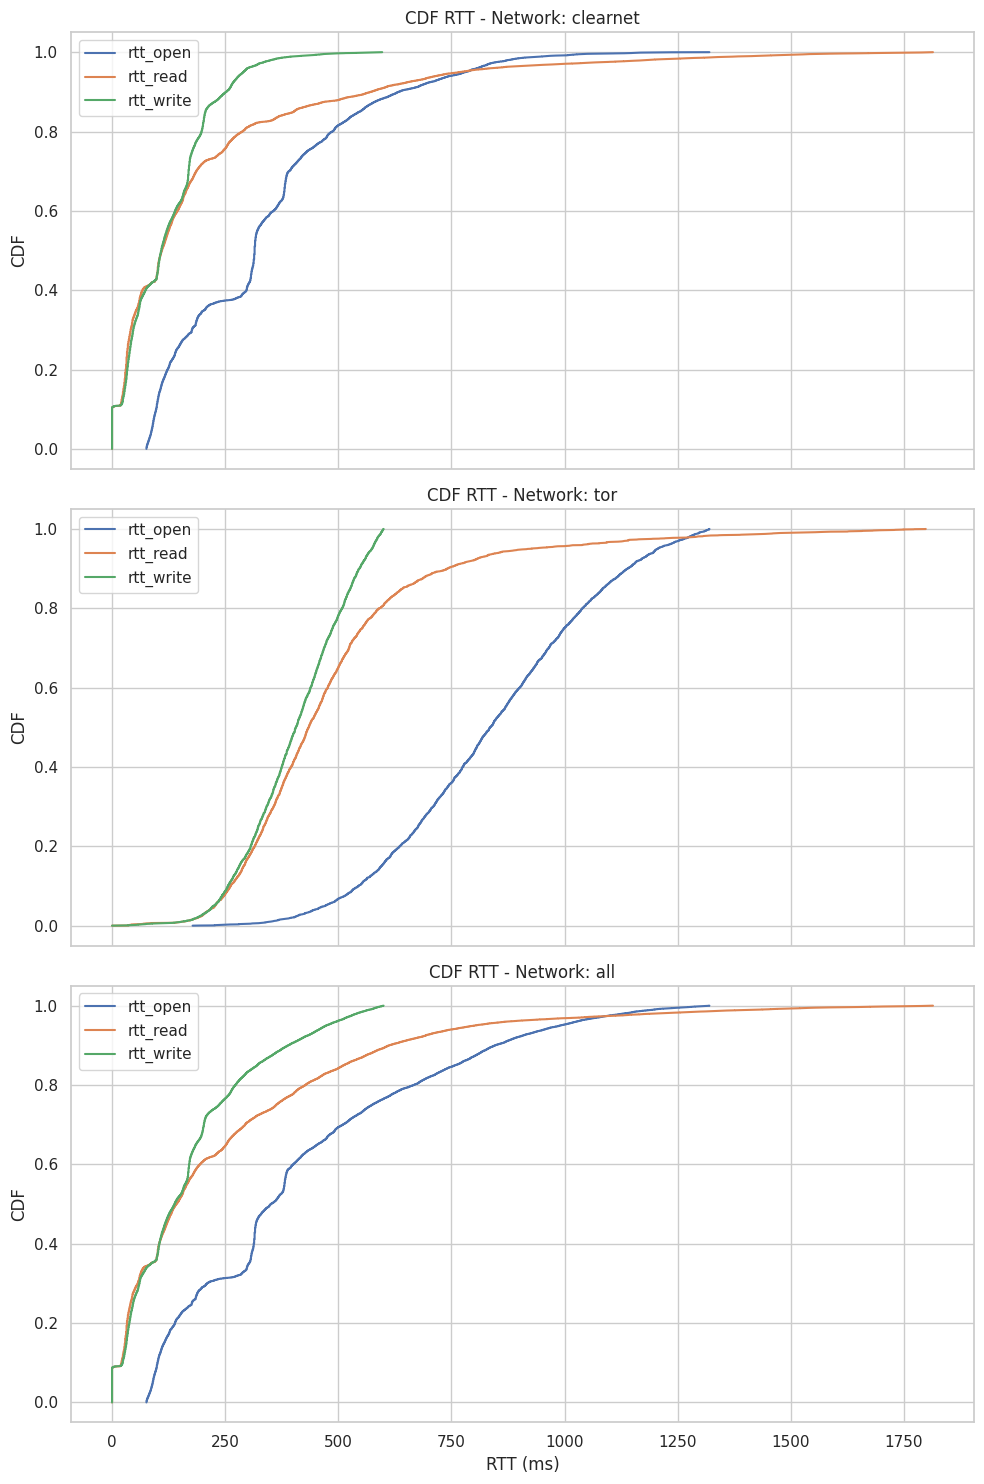

In [10]:
def plot_rtt_cdfs_by_network(df, rtt_columns, lower_pct=0.05, upper_pct=0.95):
    """
    df: dataframe con colonna 'network', colonne RTT e multi-indice (relay_id, data_misurazione)
    rtt_columns: lista colonne RTT (es. ['rtt_open', 'rtt_read', 'rtt_write'])
    lower_pct: percentile inferiore per outlier removal
    upper_pct: percentile superiore per outlier removal
    """
    df_clean = df.dropna(subset=rtt_columns).copy()

    # Filtro outlier globalmente
    for col in rtt_columns:
        low = df_clean[col].quantile(lower_pct)
        high = df_clean[col].quantile(upper_pct)
        df_clean = df_clean[(df_clean[col] >= low) & (df_clean[col] <= high)]

    n_networks = len(networks)

    fig, axes = plt.subplots(n_networks, 1, figsize=(10, 5 * n_networks), sharex=True)

    if n_networks == 1:
        axes = [axes]  # Se c'è solo un network

    for ax, net in zip(axes, networks):
        if net == 'all':
            df_net = df_clean
        else:
            df_net = df_clean[df_clean['network'] == net]
        for col in rtt_columns:
            sorted_vals = np.sort(df_net[col])
            cdf = np.linspace(0, 1, len(sorted_vals))
            ax.plot(sorted_vals, cdf, label=col)
        ax.set_title(f'CDF RTT - Network: {net}')
        ax.set_ylabel('CDF')
        ax.grid(True)
        ax.legend()

    axes[-1].set_xlabel('RTT (ms)')
    plt.tight_layout()
    plt.show()

df_tmp = tmp_daily.reset_index()  # Assicurati che 'network' sia colonna, non indice
plot_rtt_cdfs_by_network(df_tmp, ['rtt_open', 'rtt_read', 'rtt_write'], lower_pct=0.05, upper_pct=0.95)

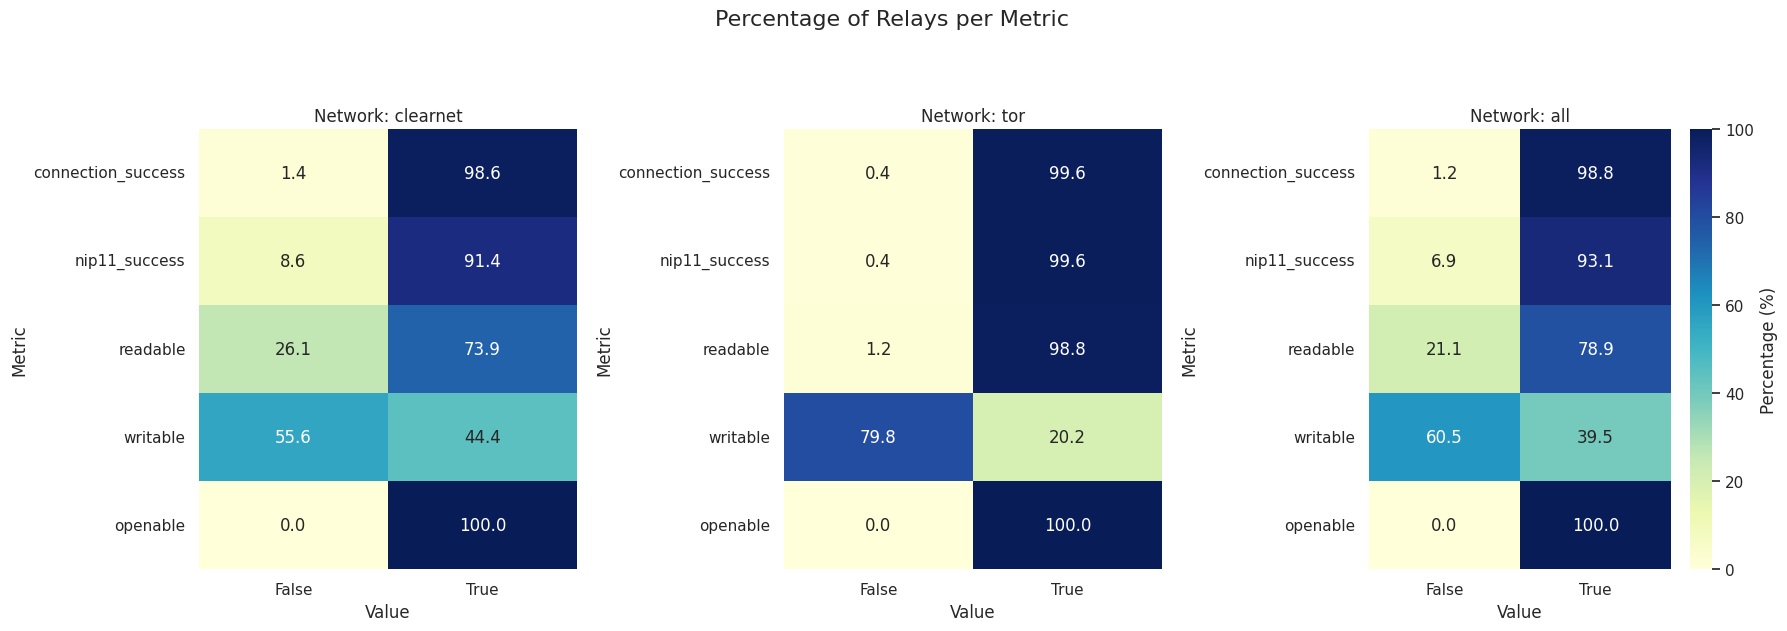

In [11]:
# Prepara i dati heatmap in un dizionario (simula il calcolo precedente)
heatmaps_data = {}

for network in networks:
    if network == 'all':
        tmp_network = tmp_daily
    else:
        tmp_network = tmp_daily[tmp_daily['network'] == network]
    mode_df = tmp_network.groupby(level=0)[metrics].agg(mode_of_series)

    mode_counts = pd.DataFrame({
        col: mode_df[col].value_counts() for col in metrics
    }).fillna(0).astype(int)

    mode_percent = mode_counts.div(mode_counts.sum(axis=0), axis=1) * 100

    heatmaps_data[network] = mode_percent.T

# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Percentage of Relays per Metric", fontsize=16, y=1.05)

for i, network in enumerate(networks):
    sns.heatmap(
        heatmaps_data[network],
        annot=True,
        fmt=".1f",
        cmap="YlGnBu",
        cbar=(i == 2),
        ax=axs[i],
        cbar_kws={'label': 'Percentage (%)'}
    )
    axs[i].set_title(f"Network: {network}", fontsize=12)
    axs[i].set_xlabel("Value")
    axs[i].set_ylabel("Metric")
    axs[i].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [12]:
mode_df = tmp_daily.groupby(level=0)[metrics+['network']].agg(mode_of_series)
for network in networks:
    if network == 'all':
        tmp_network = mode_df
    else:
        tmp_network = mode_df[mode_df['network'] == network]
    tmp_network = tmp_network.drop(columns='network')
    print(f"\nNetwork: {network}")
    display(tmp_network.value_counts().reset_index(name='count').rename(columns={'index': 'value'}).sort_values(by='count', ascending=False))


Network: clearnet


,connection_success,nip11_success,readable,writable,openable,count
0,True,True,True,True,True,417
1,True,True,True,False,True,274
2,True,True,False,False,True,199
3,True,False,False,False,True,51
4,True,False,True,False,True,20
5,True,False,True,True,True,12
6,True,True,False,True,True,4
7,True,False,False,True,True,2
8,False,True,True,False,True,1



Network: tor


,connection_success,nip11_success,readable,writable,openable,count
0,True,True,True,False,True,193
1,True,True,True,True,True,50
2,True,True,False,False,True,3
3,True,False,True,False,True,1



Network: all


,connection_success,nip11_success,readable,writable,openable,count
0,True,True,True,False,True,467
1,True,True,True,True,True,467
2,True,True,False,False,True,202
3,True,False,False,False,True,51
4,True,False,True,False,True,21
5,True,False,True,True,True,12
6,True,True,False,True,True,4
7,True,False,False,True,True,2
8,False,True,True,False,True,1


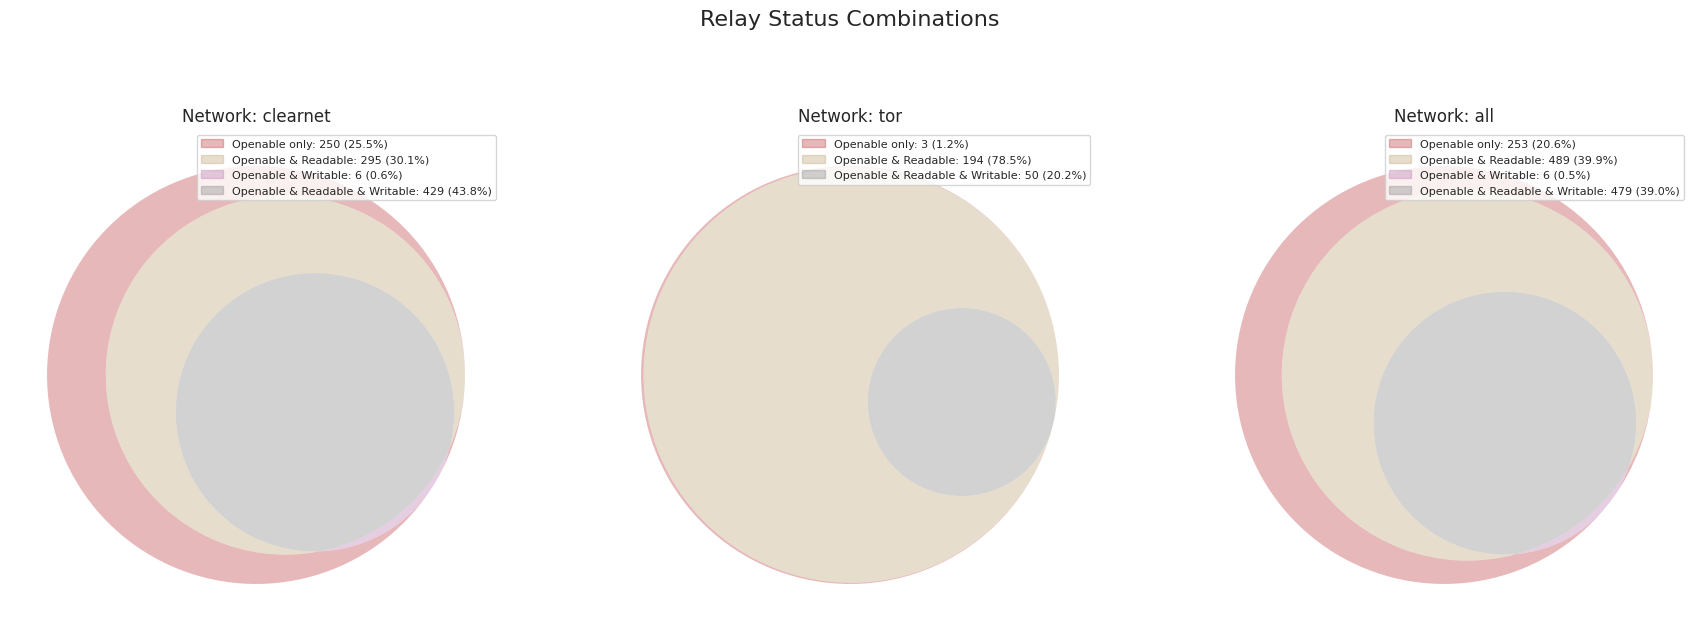

In [13]:
subset_labels = {
    '100': 'Openable only',
    '010': 'Readable only',
    '001': 'Writable only',
    '110': 'Openable & Readable',
    '101': 'Openable & Writable',
    '011': 'Readable & Writable',
    '111': 'Openable & Readable & Writable',
}

venn_sets = {}

# Prepara i set per ogni network
for network in networks:
    if network == 'all':
        tmp_network = tmp_daily
    else:
        tmp_network = tmp_daily[tmp_daily['network'] == network]
    mode_df = tmp_network.groupby(level=0)[['openable', 'readable', 'writable']].agg(mode_of_series)

    set_openable = set(mode_df[mode_df['openable'] == True].index)
    set_readable = set(mode_df[mode_df['readable'] == True].index)
    set_writable = set(mode_df[mode_df['writable'] == True].index)

    venn_sets[network] = (set_openable, set_readable, set_writable)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Relay Status Combinations", fontsize=16, y=1.05)

for i, network in enumerate(networks):
    set_openable, set_readable, set_writable = venn_sets[network]
    v = venn3([set_openable, set_readable, set_writable], ax=axs[i])

    # Nascondi nomi e numeri sui cerchi
    for text in v.set_labels:
        if text:
            text.set_visible(False)
    for subset_id in subset_labels.keys():
        label = v.get_label_by_id(subset_id)
        if label:
            label.set_text('')

    total_relays = len(set_openable.union(set_readable).union(set_writable))
    sets = [set_openable, set_readable, set_writable]

    patches = []
    for subset_id, label_text in subset_labels.items():
        patch = v.get_patch_by_id(subset_id)
        if patch:
            included_sets = [subset_id[j] == '1' for j in range(3)]

            selected = sets[0] if included_sets[0] else set()
            for j in range(1, 3):
                if included_sets[j]:
                    if selected:
                        selected = selected.intersection(sets[j])
                    else:
                        selected = sets[j]
            for j in range(3):
                if not included_sets[j]:
                    selected = selected.difference(sets[j])

            count = len(selected)
            percent = (count / total_relays * 100) if total_relays > 0 else 0
            label_with_count = f"{label_text}: {count} ({percent:.1f}%)"
            patches.append(mpatches.Patch(color=patch.get_facecolor(), label=label_with_count))

    axs[i].legend(handles=patches, loc='upper right', fontsize=8)
    axs[i].set_title(f"Network: {network}", fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [14]:
# Collect results for each relay_url
results = []

for relay_url, group in tmp_daily.groupby(level='relay_url'):
    row = {'relay_url': relay_url}
    for col in nip11_cols:
        if col not in group.columns:
            row[col] = None
            continue

        if col == 'supported_nips':
            row[col] = mode_of_lists(group[col])
        elif col in ['limitation', 'extra_fields']:
            row[col] = mode_of_dicts(group[col])
        else:
            row[col] = mode_of_series(group[col])
    row['network'] = group['network'].iloc[0]
    results.append(row)

# Convert to DataFrame
nip11_modes_df = pd.DataFrame(results).set_index('relay_url')
nip11_modes_df['supported_nips'] = nip11_modes_df['supported_nips'].apply(lambda x: np.nan if x == [] else x)
nip11_modes_df['limitation'] = nip11_modes_df['limitation'].apply(lambda x: np.nan if x == {} else x)
nip11_modes_df['extra_fields'] = nip11_modes_df['extra_fields'].apply(lambda x: np.nan if x == {} else x)

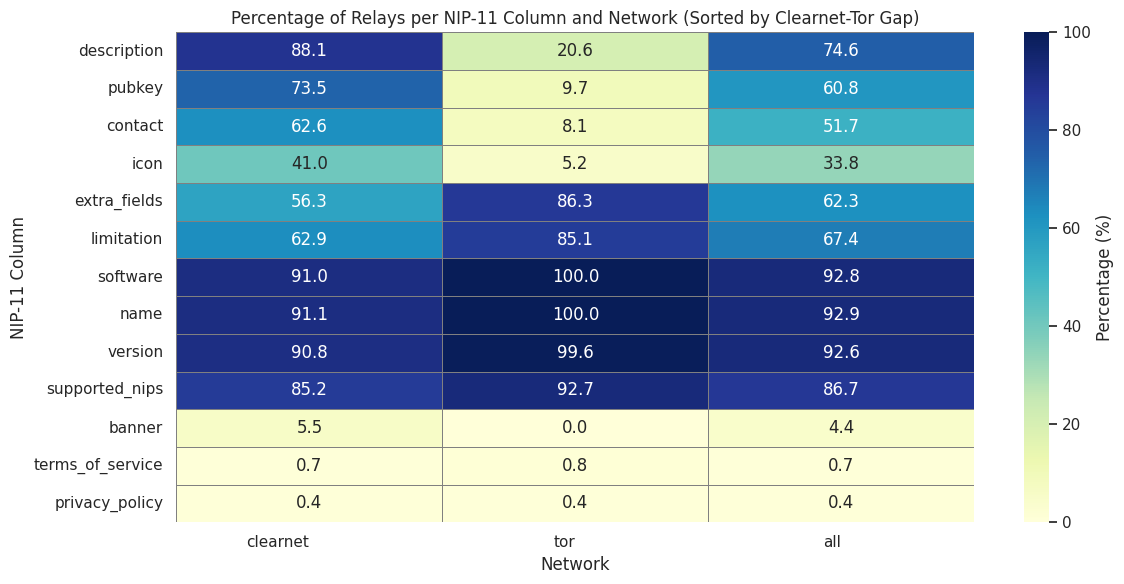

In [15]:
# Prepara un DataFrame che conterrà tutte le percentuali per network e colonne nip11
heatmap_data = pd.DataFrame(index=nip11_cols)

for network in networks:
    if network == 'all':
        tmp_network = nip11_modes_df
    else:
        tmp_network = nip11_modes_df[nip11_modes_df['network'] == network]

    percentages = []
    total_relays = tmp_network.shape[0]
    for col in nip11_cols:
        if col not in tmp_network.columns or total_relays == 0:
            perc = 0.0
        else:
            perc = (tmp_network[col].notna().sum() / total_relays) * 100
        percentages.append(perc)
    heatmap_data[network] = percentages

# Calcola il divario assoluto tra clearnet e tor
if 'clearnet' in heatmap_data.columns and 'tor' in heatmap_data.columns:
    heatmap_data['divario'] = (heatmap_data['clearnet'] - heatmap_data['tor']).abs()
    heatmap_data = heatmap_data.sort_values(by='divario', ascending=False)
    heatmap_data = heatmap_data.drop(columns='divario')

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",  # più indicato per divergenze
    cbar_kws={'label': 'Percentage (%)'},
    linewidths=0.5,
    linecolor='gray'
)

plt.title("Percentage of Relays per NIP-11 Column and Network (Sorted by Clearnet-Tor Gap)")
plt.ylabel("NIP-11 Column")
plt.xlabel("Network")
plt.xticks(rotation=0, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


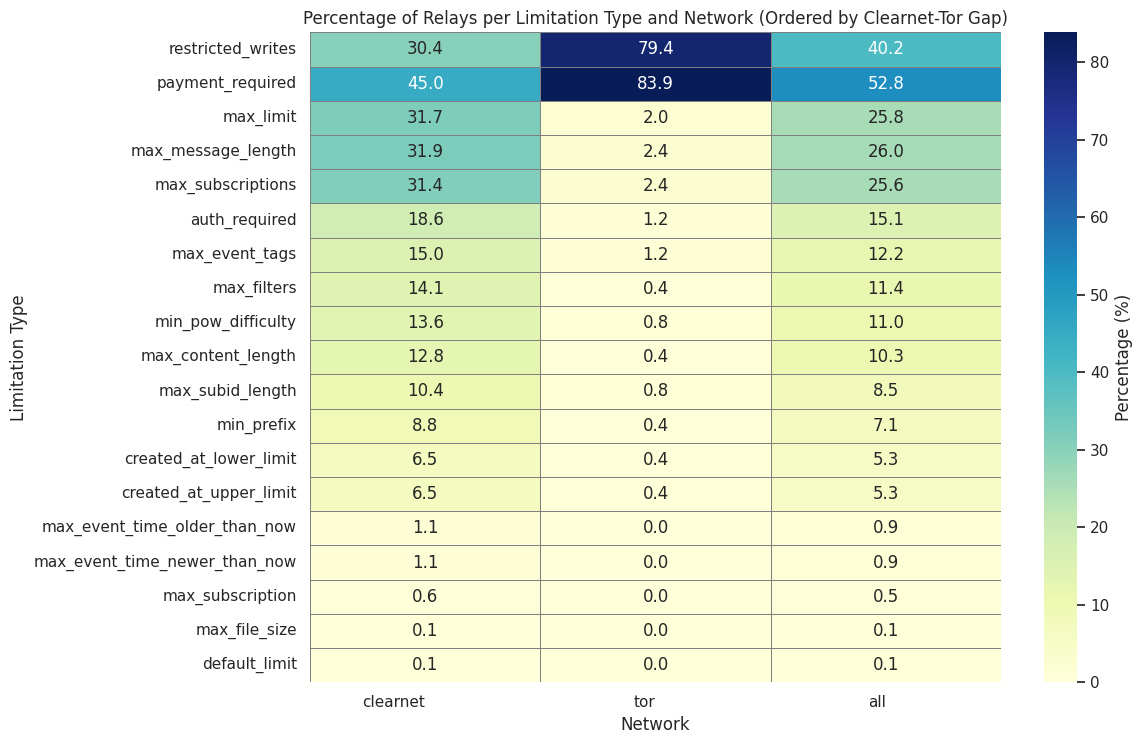

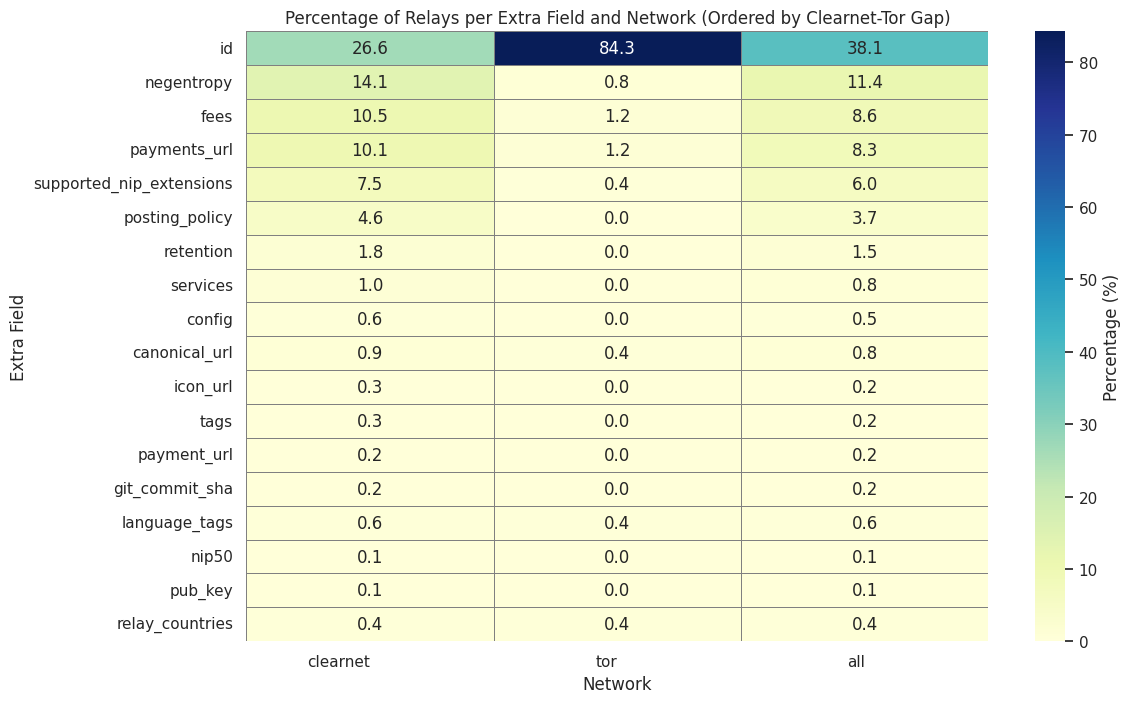

In [16]:
def calc_heatmap_data_for_dict_column(df, networks, col_name, sort_by_gap=True):
    all_keys = set()
    for _, row in df.iterrows():
        d = row[col_name]
        if isinstance(d, dict):
            all_keys.update(d.keys())
    all_keys = sorted(all_keys)

    heatmap_data = pd.DataFrame(index=all_keys)

    for network in networks:
        if network == 'all':
            tmp_network = df
        else:
            tmp_network = df[df['network'] == network]

        total_relays = tmp_network.shape[0]
        percentages = []
        for key in all_keys:
            if total_relays == 0:
                perc = 0.0
            else:
                count = tmp_network[col_name].apply(lambda d: isinstance(d, dict) and key in d).sum()
                perc = (count / total_relays) * 100
            percentages.append(perc)
        heatmap_data[network] = percentages

    if sort_by_gap and 'clearnet' in heatmap_data.columns and 'tor' in heatmap_data.columns:
        heatmap_data['gap'] = (heatmap_data['clearnet'] - heatmap_data['tor']).abs()
        heatmap_data = heatmap_data.sort_values('gap', ascending=False).drop(columns='gap')
    else:
        heatmap_data['total'] = heatmap_data.sum(axis=1)
        heatmap_data = heatmap_data.sort_values('total', ascending=False).drop(columns='total')

    return heatmap_data


# Calcola heatmap per limitation ordinata
heatmap_limitation = calc_heatmap_data_for_dict_column(nip11_modes_df, networks, 'limitation')

# Calcola heatmap per extra_fields ordinata
heatmap_extra_fields = calc_heatmap_data_for_dict_column(nip11_modes_df, networks, 'extra_fields')


# Plot heatmap limitation
plt.figure(figsize=(12, max(6, len(heatmap_limitation)*0.4)))
sns.heatmap(
    heatmap_limitation,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Percentage (%)'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title("Percentage of Relays per Limitation Type and Network (Ordered by Clearnet-Tor Gap)")
plt.ylabel("Limitation Type")
plt.xlabel("Network")
plt.xticks(rotation=0, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Plot heatmap extra_fields
plt.figure(figsize=(12, max(6, len(heatmap_extra_fields)*0.4)))
sns.heatmap(
    heatmap_extra_fields,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Percentage (%)'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title("Percentage of Relays per Extra Field and Network (Ordered by Clearnet-Tor Gap)")
plt.ylabel("Extra Field")
plt.xlabel("Network")
plt.xticks(rotation=0, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [17]:
mode_relays = pd.merge(
    tmp_daily.groupby(level=0)[metrics].agg(mode_of_series).reset_index(),
    nip11_modes_df.reset_index()
)

Number of relays in cleanet and tor: 1241
Number of relays in cleanet: 993
Number of relays in tor: 248


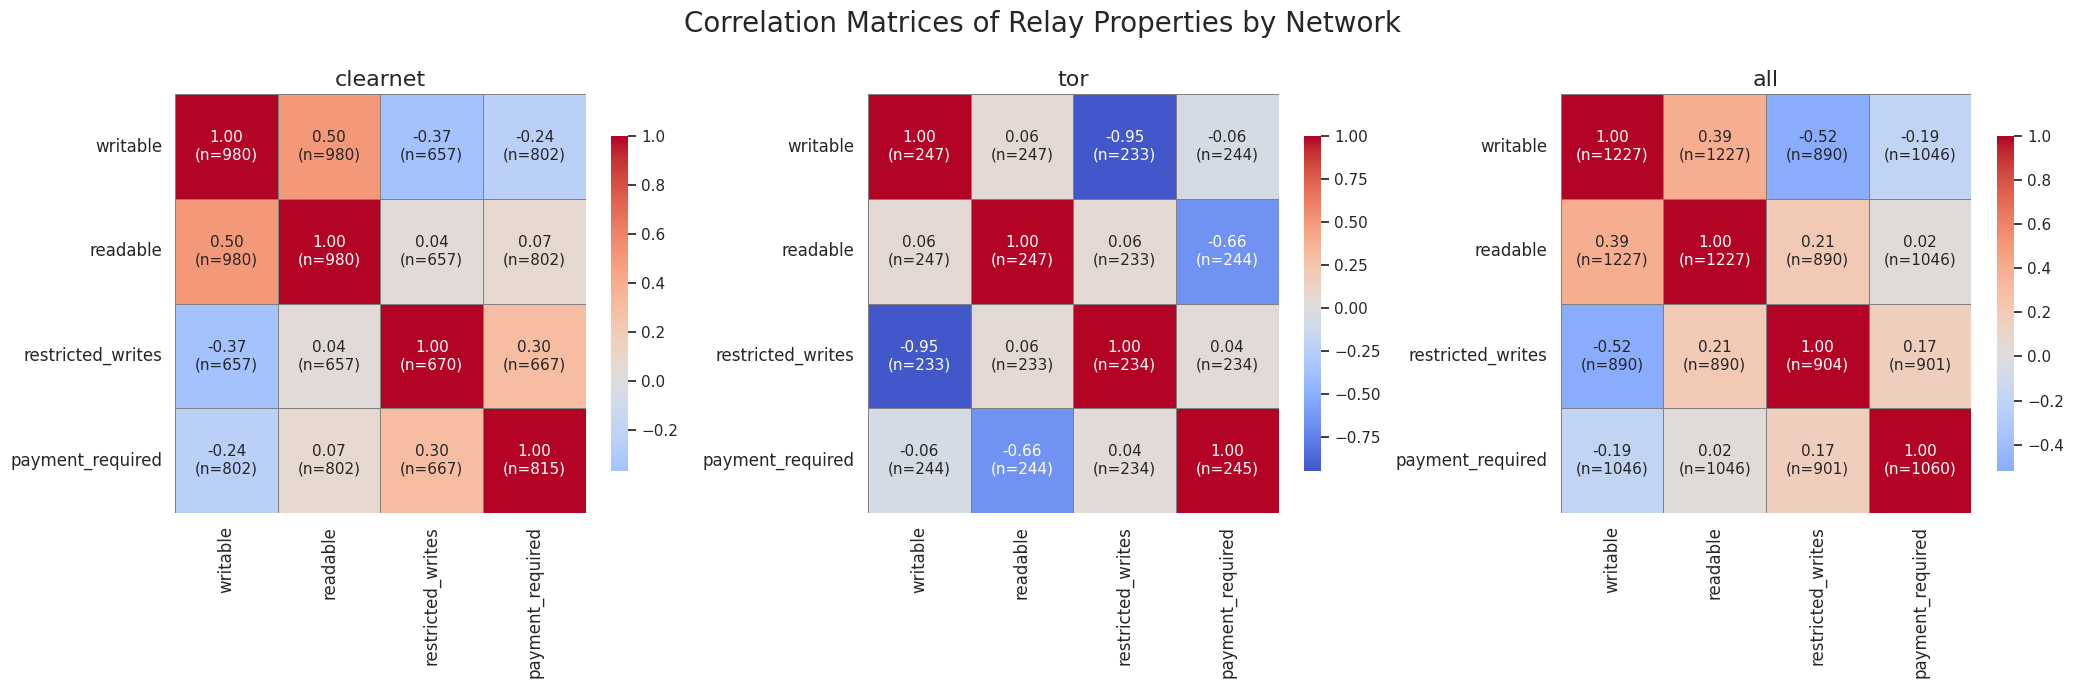

In [18]:
# Prepara i dati
tmp_mode = mode_relays.filter(['relay_url', 'network', 'writable', 'readable', 'limitation']).copy()
tmp_mode['restricted_writes'] = tmp_mode['limitation'].apply(lambda x: x.get('restricted_writes', None) if isinstance(x, dict) else False)
tmp_mode['payment_required'] = tmp_mode['limitation'].apply(lambda x: x.get('payment_required', None) if isinstance(x, dict) else False)
tmp_mode = tmp_mode.drop(columns='limitation')
tmp_mode = tmp_mode.set_index(['relay_url', 'network'])

# print number of relays
print(f"Number of relays in cleanet and tor: {tmp_mode.shape[0]}")
print(f"Number of relays in cleanet: {tmp_mode.xs('clearnet', level='network').shape[0]}")
print(f"Number of relays in tor: {tmp_mode.xs('tor', level='network').shape[0]}")

# Numero di heatmap da plottare
n = len(networks)
fig, axes = plt.subplots(1, n, figsize=(7 * n, 7))  # figura più larga e alta

# Se c'è un solo network, axes non è una lista → forzalo
if n == 1:
    axes = [axes]

for ax, network in zip(axes, networks):
    if network == 'all':
        group = tmp_mode.copy()
    else:
        group = tmp_mode.xs(network, level='network')

    corr_matrix = group.corr()

    # Calcolo della matrice con numero di coppie valide
    valid_counts = pd.DataFrame(
        np.zeros_like(corr_matrix, dtype=int),
        index=corr_matrix.index,
        columns=corr_matrix.columns
    )

    for col1 in group.columns:
        for col2 in group.columns:
            valid_counts.loc[col1, col2] = group[[col1, col2]].dropna().shape[0]

    # Prepara annotazioni combinate: "r=0.75\n(n=123)"
    annot_matrix = corr_matrix.copy()
    for i in corr_matrix.index:
        for j in corr_matrix.columns:
            r = corr_matrix.loc[i, j]
            n = valid_counts.loc[i, j]
            annot_matrix.loc[i, j] = f"{r:.2f}\n(n={n})"

    sns.heatmap(
        corr_matrix,
        annot=annot_matrix,
        fmt="",  # fmt vuoto perché l'annotazione è già formattata
        cmap="coolwarm",
        center=0,
        linewidths=0.7,
        linecolor='gray',
        annot_kws={"size": 11},
        cbar_kws={'shrink': 0.8},
        ax=ax
    )
    ax.set_title(f"{network}", fontsize=16)
    ax.tick_params(axis='x', rotation=90, labelsize=12)
    ax.tick_params(axis='y', rotation=0, labelsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.92])  # spazio per il titolo
plt.subplots_adjust(wspace=0.35)  # più spazio fra i plot
plt.suptitle("Correlation Matrices of Relay Properties by Network", fontsize=20)
plt.show()

In [19]:
for network in networks:
    if network == 'all':
        group = tmp_mode.copy()
    else:
        group = tmp_mode.xs(network, level='network')

    print(f"\nNetwork: {network}")
    display(group.value_counts().rename('count').reset_index().sort_values(by='count', ascending=False))


Network: clearnet


,writable,readable,restricted_writes,payment_required,count
0,True,True,False,False,272
1,False,False,False,False,177
2,False,True,False,False,97
3,False,True,True,False,67
4,False,False,True,False,24
5,False,True,True,True,7
6,True,False,False,False,5
7,False,False,True,True,4
8,True,True,True,False,1



Network: tor


,writable,readable,restricted_writes,payment_required,count
0,False,True,True,False,181
1,True,True,False,False,47
2,False,True,False,False,3
3,False,False,False,False,1
4,False,False,True,True,1



Network: all


,writable,readable,restricted_writes,payment_required,count
0,True,True,False,False,319
1,False,True,True,False,248
2,False,False,False,False,178
3,False,True,False,False,100
4,False,False,True,False,24
5,False,True,True,True,7
6,False,False,True,True,5
7,True,False,False,False,5
8,True,True,True,False,1


In [20]:
if 'relay_synchronization.csv' not in os.listdir(DATA_FOLDER):
    query = """
    SELECT
        latest.relay_url AS relay_url,
        e.created_at AS timestamp,
        latest.seen_at AS seen_at
    FROM (
        SELECT DISTINCT ON (relay_url)
            relay_url,
            seen_at,
            event_id
        FROM
            events_relays
        ORDER BY
            relay_url,
            seen_at DESC
    ) AS latest
    JOIN events e ON e.id = latest.event_id;
    """
    with bigbrotr.cursor() as cursor:
        cursor.execute(query)
        rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=['relay_url', 'timestamp', 'seen_at'])
    df['timestamp_month'] = pd.to_datetime(df['timestamp'], unit='s').dt.to_period('M')
    df['seen_at_day'] = pd.to_datetime(df['seen_at'], unit='s').dt.to_period('D')
    df = df.sort_values(by=['seen_at_day', 'timestamp_month'], ascending=True)
    df.to_csv(os.path.join(DATA_FOLDER, 'relay_synchronization.csv'), index=False)
relay_synchronization = pd.read_csv(os.path.join(DATA_FOLDER, 'relay_synchronization.csv'))

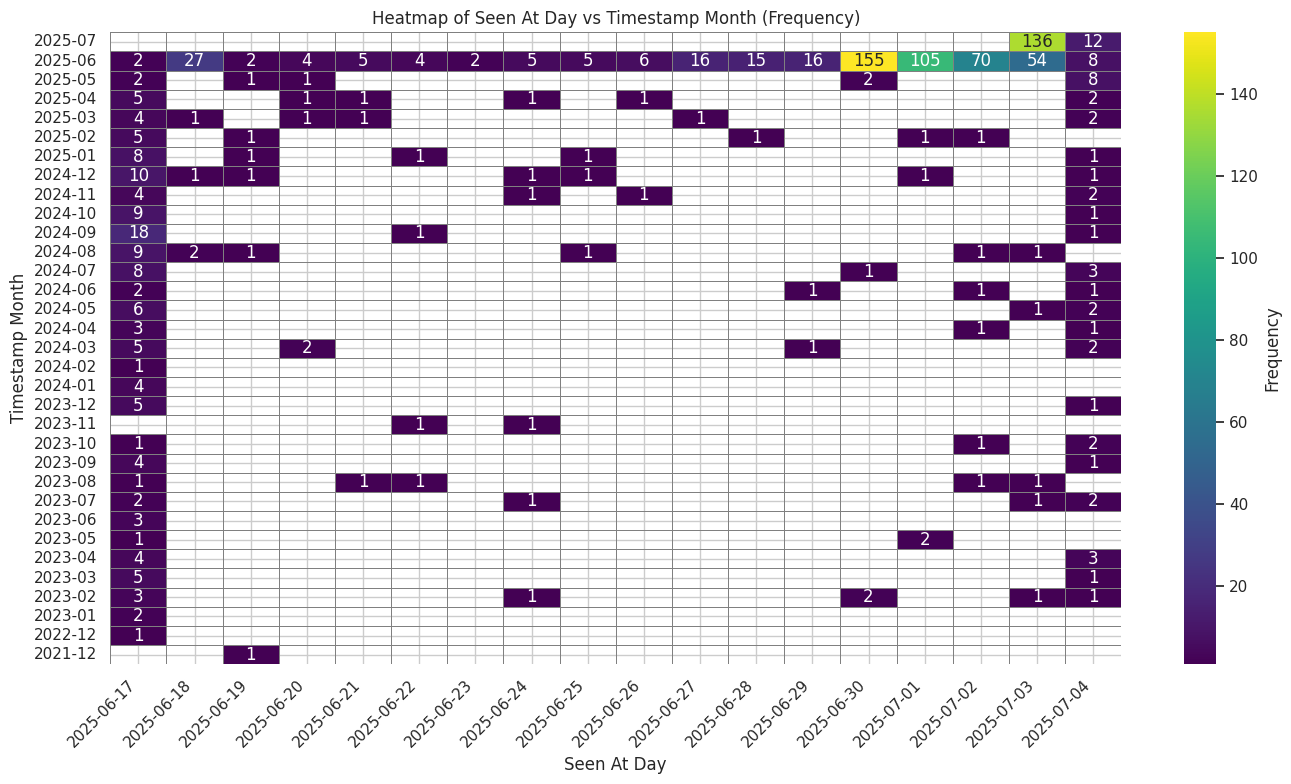

In [21]:
# Copia temporanea
tmp = relay_synchronization.copy()

tmp['timestamp_month_dt'] = tmp['timestamp_month']
tmp['seen_at_day_dt'] = tmp['seen_at_day']

# Calcola frequenze
tmp = (
    tmp.groupby(['timestamp_month_dt', 'seen_at_day_dt'])
    .size()
    .reset_index(name='frequency')
)

# Pivot
heatmap_data = tmp.pivot(index='timestamp_month_dt', columns='seen_at_day_dt', values='frequency')

# Ordina l’asse Y dal più recente al meno recente
heatmap_data = heatmap_data.sort_index(ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    cmap='viridis',
    annot=True,
    fmt='g',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Frequency'},
    ax=ax
)

# Format x-axis (daily)
ax.set_xlabel("Seen At Day")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Format y-axis (monthly)
ax.set_ylabel("Timestamp Month")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Titolo
ax.set_title("Heatmap of Seen At Day vs Timestamp Month (Frequency)")

plt.tight_layout()
plt.show()

In [22]:
if 'relay_event_counts.csv' not in os.listdir(DATA_FOLDER):
    query = """
    SELECT 
        relay_url,
        COUNT(*) AS event_count
    FROM 
        events_relays
    GROUP BY 
        relay_url
    ORDER BY 
        event_count ASC;
    """
    df = pd.read_sql(query, bigbrotr)
    df.to_csv(os.path.join(DATA_FOLDER, 'relay_event_counts.csv'), index=False)

relay_event_counts = pd.read_csv(os.path.join(DATA_FOLDER, 'relay_event_counts.csv'))
relay_event_counts = pd.merge(
    relay_event_counts,
    relay_metadata.filter(['relay_url', 'network']).drop_duplicates(),
    on='relay_url'
)


Top 3 relays with most events in clearnet:
- wss://relay.nostr.band: 44635361 events
- wss://a.nos.lol: 19150103 events
- wss://nos.lol: 12103793 events
- wss://dave.st.germa.in/nostr: 12103598 events
- wss://nostr-01.yakihonne.com: 10262997 events

Top 3 relays with most events in tor:
- wss://oxtrdevav64z64yb7x6rjg4ntzqjhedm5b5zjqulugknhzr46ny2qbad.onion: 8726537 events
- wss://sovbitm2enxfr5ot6qscwy5ermdffbqscy66wirkbsigvcshumyzbbqd.onion: 7390935 events
- wss://3rpykuwfpgjijym45svczvzpbur6t6x4b67lnvp6wxdre2cqoy6a4dyd.onion: 202968 events
- wss://sovbitgz5uqyh7jwcsudq4sspxlj4kbnurvd3xarkkx2use3k6rlibqd.onion: 78420 events
- wss://cmuqxreb6oma3x3iq3zh62im7w4266uo3txac6e75qtlfqs7scwqyqyd.onion: 45099 events


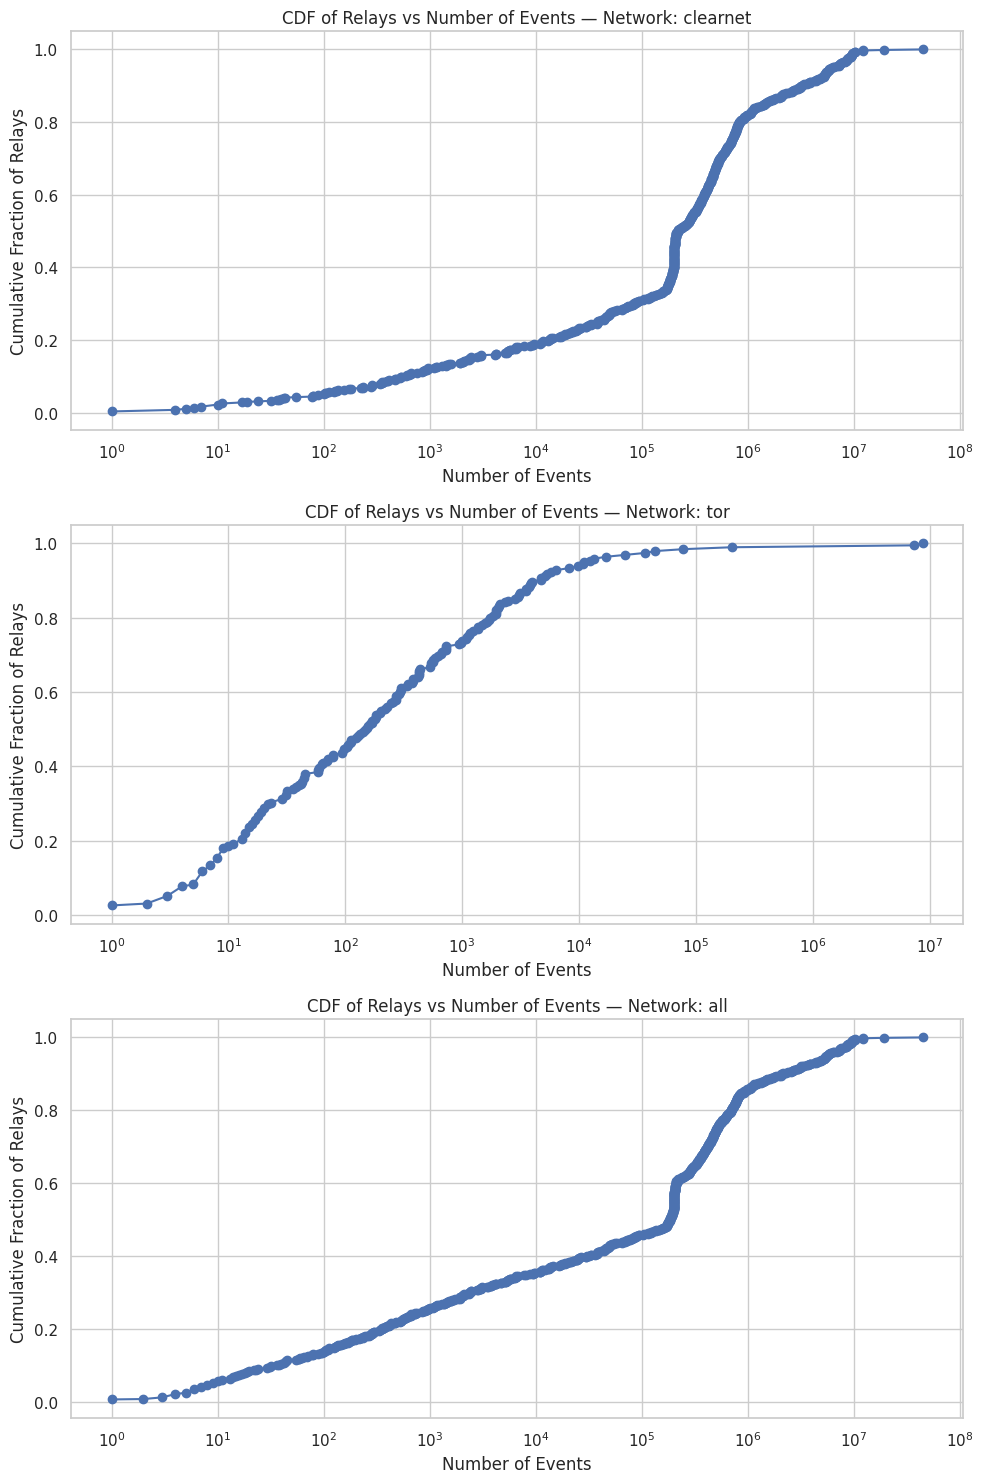

In [23]:
# Una colonna, tante righe quanti sono i network
fig, axes = plt.subplots(len(networks), 1, figsize=(10, 5 * len(networks)), sharex=False)
if len(networks) == 1:
    axes = [axes]  # Garantisce che axes sia sempre iterabile

# Genera un plot per ogni network
for i, network in enumerate(networks):
    ax = axes[i]
    if network == 'all':
        sub_df = relay_event_counts
    else:
        sub_df = relay_event_counts[relay_event_counts['network'] == network]
    
    # print top 3 relays with most events
    if network != 'all':
        top_relays = sub_df.nlargest(5, 'event_count')
        print(f"\nTop 3 relays with most events in {network}:")
        for _, row in top_relays.iterrows():
            print(f"- {row['relay_url']}: {row['event_count']} events")
        
    # Calcola CDF
    cdf = sub_df['event_count'].value_counts().sort_index().cumsum() / sub_df['event_count'].count()
    
    ax.plot(cdf.index, cdf.values, marker='o')
    ax.set_title(f'CDF of Relays vs Number of Events — Network: {network}')
    ax.set_xlabel('Number of Events')
    ax.set_ylabel('Cumulative Fraction of Relays')
    ax.set_xscale('log')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [24]:
relay_data = pd.merge(
    relay_metadata.filter(['relay_url', 'network']).drop_duplicates(),
    relay_synchronization,
    on='relay_url'
)
relay_data = pd.merge(
    relay_data,
    relay_event_counts.drop(columns='network'),
    on='relay_url'
)

In [25]:
relay_data[relay_data['relay_url'].str.contains('oxt')]

,relay_url,network,timestamp,seen_at,timestamp_month,seen_at_day,event_count
19,wss://nostr.oxtr.dev,clearnet,1751188203,1751417168,2025-06,2025-07-02,8576968
134,wss://oxtrdevav64z64yb7x6rjg4ntzqjhedm5b5zjqul...,tor,1751371575,1751588624,2025-07,2025-07-04,8726537


In [26]:
relay_data[relay_data['relay_url'].str.contains('sov')]

,relay_url,network,timestamp,seen_at,timestamp_month,seen_at_day,event_count
275,wss://sovbitm2enxfr5ot6qscwy5ermdffbqscy66wirk...,tor,1751473067,1751576506,2025-07,2025-07-03,7390935
358,wss://sovbitgz5uqyh7jwcsudq4sspxlj4kbnurvd3xar...,tor,1751166521,1751289267,2025-06,2025-06-30,78420
387,wss://freelay.sovbit.host,clearnet,1751473181,1751576877,2025-07,2025-07-03,7396293
396,wss://nostr.sovbit.host,clearnet,1751056247,1751415488,2025-06,2025-07-02,78415


In [27]:
bigbrotr.close()